In [ ]:
# how to install packages for all the environments, very useful
# import sys
# !{sys.executable} -m pip install xgboost

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

os.getcwd()

'/home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project/code/XGBoost Model Training'

In [11]:
# define a function that does either a randomized search or a grid search

def grid_search(x_dat, y_dat, n_cv, n_iterations, params, random=False):
    print("---- Grid search started ----")
    xgb = XGBRegressor(booster='gbtree', tree_method = 'hist', 
                       objective='reg:squarederror', random_state=2)
    
    if random:
        tune_model = RandomizedSearchCV(xgb, params, cv= n_cv, n_iter= n_iterations, scoring = 'r2', n_jobs=-1)
    else:
        tune_model = GridSearchCV(xgb, params, cv= n_cv, n_jobs=-1)

    tune_model.fit(x_dat, y_dat)

    # Extract best params
    best_params = tune_model.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = tune_model.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))
    
    return tune_model

In [ ]:
#### 1. train UFP number model #### 


In [12]:
# 1.a read in the metadata file
    # file needs to have CNN predictions
    # there may be a new file for each site

project_dir = os.getcwd()

# removing 'code' from the file path
compiled_data_dir = project_dir.split('code', 1)[0] + 'compiled data/rishabh/'
dat_name_path = compiled_data_dir + 'metadata_gopro_training_only_UFP_V2_V3_04252024_predictions_added.csv'
print("CSV file loaded: ", dat_name_path)

# print("project_dir: ", project_dir)
# print("compiled_data_dir:",compiled_data_dir)
# print("dat_name_path: ", dat_name_path)

dat = pd.read_csv(dat_name_path)

# some other metadata files
    # metadata_goproUFP_V2_V3_15012024_predictions_added.csv
    # version_3_compiled_data_13112023_with_predictions.csv
    # metadata_goproUFP_V2_V3_15012024_predictions_added.csv

CSV file loaded:  /home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project/compiled data/rishabh/metadata_gopro_training_only_UFP_V2_V3_04252024_predictions_added.csv


/tmp/ipykernel_16697/3809498850.py:16: DtypeWarning: Columns (22,24,31,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(dat_name_path)


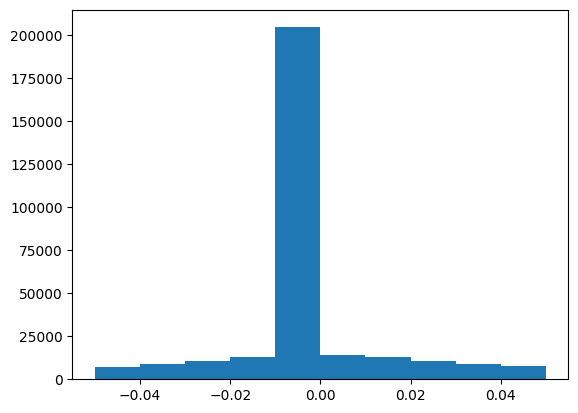

In [13]:
# 1.b if using V2, get rid of all the rows where spec and image labels are very different
dat['diff_col'] = dat.apply(lambda value: value.ln_ufp_num_10s_ma_image_label_raw - value.ln_ufp_num_10s_ma_spec_label_raw, axis = 1)

dat = dat.loc[(abs(dat['diff_col']) <= 0.05)]

# plot to confirm
plt.hist(dat['diff_col'])
plt.show()

In [14]:
[*dat]

['datetime',
 'image_path',
 'audio_path',
 'ln_ufp_num_10s_ma_image_label_raw',
 'ln_ufp_num_10s_ma_spec_label_raw',
 'ln_ufp_size_10s_ma_image_label_raw',
 'ln_ufp_size_10s_ma_spec_label_raw',
 'ln_noise_10s_ma_image_label_raw',
 'ln_noise_10s_ma_spec_label_raw',
 'ufp_num_10s_ma_image_label_raw',
 'ufp_num_10s_ma_spec_label_raw',
 'ufp_size_10s_ma_image_label_raw',
 'ufp_size_10s_ma_spec_label_raw',
 'noise_10s_ma_image_label_raw',
 'noise_10s_ma_spec_label_raw',
 'temp_airp',
 'wspd_airp',
 'year',
 'city',
 'pm25',
 'file_exists',
 'hardware',
 'site_id',
 'device_id',
 'file',
 'noise_10s_ma_spec_label_quartile',
 'noise_10s_ma_image_label_quartile',
 'ufp_num_10s_ma_spec_label_quartile',
 'ufp_num_10s_ma_image_label_quartile',
 'ufp_size_10s_ma_spec_label_quartile',
 'ufp_size_10s_ma_image_label_quartile',
 'image_extension',
 'audio_extension',
 'image_name',
 'audio_name',
 'pair_pm25',
 'set_V3ext',
 'set',
 'vsby_nm',
 'ln_ufp_num_convnext_image_raw_prediction',
 'ln_ufp_num

In [15]:
######### 1.c subset to filter the temporal adjustment data #######
# conditions: the value in the 'hardware' column must be 'V2' and the value in the 'set' column must be 'tst'
# this may change depending on the site or which model we find works best

dat = dat.loc[(dat['hardware'] == 'V2') & (dat['set'] == 'tst')]

In [16]:
# 1.d. prep data for XGBoost training

# selecting and renaming columns
best_model = input("Input the best model name: ")

train_dat = dat.loc[:, ["ufp_num_10s_ma_image_label_raw", 
    "temp_airp",
    "wspd_airp",
    # dat is missing ln_ufp_..._Xception predictions
    f"ln_ufp_num_{best_model}_image_raw_prediction", 
    f"ln_ufp_num_{best_model}_audio_raw_prediction", 
    f"ln_ufp_size_{best_model}_image_raw_prediction", 
    f"ln_ufp_size_{best_model}_audio_raw_prediction"]]

# # create new colums, mean predictions and the log transformed outcome
# train_dat.loc[:,['mean_ufp_num_pred_images']] = train_dat.apply(lambda value: value.ufp_num_pred_images_resnet + value.ufp_num_pred_images_xception, axis = 1)
# train_dat.loc[:,['mean_ufp_num_pred_spectrogram']] = train_dat.apply(lambda value: value.ufp_num_pred_spectrogram_resnet + value.ufp_num_pred_spectrogram_xception, axis = 1)
# train_dat.loc[:,['mean_ufp_size_pred_images']] = train_dat.apply(lambda value: value.ufp_size_pred_images_resnet + value.ufp_size_pred_images_xception, axis = 1)
# train_dat.loc[:,['mean_ufp_size_pred_spectrogram']] = train_dat.apply(lambda value: value.ufp_size_pred_spectrogram_resnet + value.ufp_size_pred_spectrogram_xception, axis = 1)
# train_dat.loc[:,['ln_ufp_num_raw']] = train_dat.apply(lambda value: np.log(value.ufp_num_10s_ma_image_label_raw), axis = 1)

# # a bit overdone, this is just duplicating the ResNet50 columns with new names that fit the work flow, but this could easily add the Xception if/when they are there
# train_dat.loc[:,['mean_ufp_num_pred_images']] = train_dat.apply(lambda value: value.ln_ufp_num_convnext_image_raw_prediction, axis = 1)
# train_dat.loc[:,['mean_ufp_num_pred_spectrogram']] = train_dat.apply(lambda value: value.ln_ufp_num_convnext_audio_raw_prediction, axis = 1)
# train_dat.loc[:,['mean_ufp_size_pred_images']] = train_dat.apply(lambda value: value.ln_ufp_size_convnext_image_raw_prediction, axis = 1)
# train_dat.loc[:,['mean_ufp_size_pred_spectrogram']] = train_dat.apply(lambda value: value.ln_ufp_size_convnext_audio_raw_prediction, axis = 1)
# train_dat.loc[:,['ln_ufp_num_raw']] = train_dat.apply(lambda value: np.log(value.ufp_num_10s_ma_image_label_raw), axis = 1)

train_dat.loc[:, ['mean_ufp_num_pred_images']] = train_dat.apply(lambda value: value[f'ln_ufp_num_{best_model}_image_raw_prediction'], axis=1)
train_dat.loc[:, ['mean_ufp_num_pred_spectrogram']] = train_dat.apply(lambda value: value[f'ln_ufp_num_{best_model}_audio_raw_prediction'], axis=1)
train_dat.loc[:, ['mean_ufp_size_pred_images']] = train_dat.apply(lambda value: value[f'ln_ufp_size_{best_model}_image_raw_prediction'], axis=1)
train_dat.loc[:, ['mean_ufp_size_pred_spectrogram']] = train_dat.apply(lambda value: value[f'ln_ufp_size_{best_model}_audio_raw_prediction'], axis=1)
train_dat.loc[:, ['ln_ufp_num_raw']] = train_dat.apply(lambda value: np.log(value.ufp_num_10s_ma_image_label_raw), axis=1)


train_dat

Input the best model name: convnext


,ufp_num_10s_ma_image_label_raw,temp_airp,wspd_airp,ln_ufp_num_convnext_image_raw_prediction,ln_ufp_num_convnext_audio_raw_prediction,ln_ufp_size_convnext_image_raw_prediction,ln_ufp_size_convnext_audio_raw_prediction,mean_ufp_num_pred_images,mean_ufp_num_pred_spectrogram,mean_ufp_size_pred_images,mean_ufp_size_pred_spectrogram,ln_ufp_num_raw
167238,15517.2,7.9,17,9.847296,10.120522,3.514957,3.201614,9.847296,10.120522,3.514957,3.201614,9.649704
167246,11427.6,8.0,18,9.625559,10.019504,3.674605,3.239304,9.625559,10.019504,3.674605,3.239304,9.343787
167287,14912.8,8.0,18,9.942196,10.014131,3.142466,3.084479,9.942196,10.014131,3.142466,3.084479,9.609975
167297,14158.3,8.0,18,9.811390,9.456086,3.282415,3.367019,9.811390,9.456086,3.282415,3.367019,9.558056
167338,9554.5,7.8,21,9.656521,10.050273,3.434078,3.203852,9.656521,10.050273,3.434078,3.203852,9.164768
...,...,...,...,...,...,...,...,...,...,...,...,...
366887,8526.7,21.7,11,9.509497,9.181280,3.640786,3.394962,9.509497,9.181280,3.640786,3.394962,9.050958
366890,18265.7,21.7,11,9.525852,9.495868,3.378793,3.443834,9.525852,9.495868,3.378793,3.443834,9.812780
366912,21767.4,21.5,17,9.285892,9.353752,3.374171,3.587228,9.285892,9.353752,3.374171,3.587228,9.988169
366948,17676.6,21.5,17,9.929644,9.356776,3.430787,3.446152,9.929644,9.356776,3.430787,3.446152,9.779997


In [17]:
train_dat.dtypes

ufp_num_10s_ma_image_label_raw               float64
temp_airp                                    float64
wspd_airp                                      int64
ln_ufp_num_convnext_image_raw_prediction     float64
ln_ufp_num_convnext_audio_raw_prediction     float64
ln_ufp_size_convnext_image_raw_prediction    float64
ln_ufp_size_convnext_audio_raw_prediction    float64
mean_ufp_num_pred_images                     float64
mean_ufp_num_pred_spectrogram                float64
mean_ufp_size_pred_images                    float64
mean_ufp_size_pred_spectrogram               float64
ln_ufp_num_raw                               float64
dtype: object

In [18]:
# define predictors and target, windspeed included
X_predictors, y_target = train_dat.loc[:,['mean_ufp_num_pred_images', 'mean_ufp_num_pred_spectrogram', 'mean_ufp_size_pred_spectrogram', 'mean_ufp_size_pred_images', 'temp_airp', 'wspd_airp']], train_dat.loc[:,'ln_ufp_num_raw']

# do without windspeed for now
# X_predictors, y_target = train_dat.loc[:,['mean_ufp_num_pred_images', 'mean_ufp_num_pred_spectrogram', 'mean_ufp_size_pred_spectrogram', 'mean_ufp_size_pred_images', 'temp_airp']], train_dat.loc[:,'ln_ufp_num_raw']

X_predictors_train, X_predictors_test, y_target_train, y_target_test = train_test_split(X_predictors, y_target, random_state = 1)

X_predictors.dtypes

mean_ufp_num_pred_images          float64
mean_ufp_num_pred_spectrogram     float64
mean_ufp_size_pred_spectrogram    float64
mean_ufp_size_pred_images         float64
temp_airp                         float64
wspd_airp                           int64
dtype: object

In [19]:
# 1.e. define the ranges of the parameters we want to tune. I took these values from R code
# experiment with different ranges

my_params = {'learning_rate': np.linspace(0,1,11),
             'gamma': list(range(0,11,1)),
             'max_depth': list(range(1, 11, 1)),
             'min_child_weight': list(range(1,201,10)),
             'colsample_bytree': np.linspace(0.2,1,9),
             'colsample_bynode': np.linspace(0.2,1,9), 
             'colsample_bylevel': np.linspace(0.2,1,9), 
            }
 

In [20]:
# 1.f. tune and evaluate model

# tune model over range of parameters
random_search_model = grid_search(x_dat = X_predictors_train, y_dat = y_target_train, 
                                  n_cv = 10, n_iterations = 5000,
                                  params = my_params, 
                                  random = True)

---- Grid search started ----
Best params: {'min_child_weight': 21, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.9000000000000001, 'colsample_bylevel': 0.9000000000000001}
Best score: 0.87719


In [21]:
# use tuned values to train model and evaluate in CV in training set
tuned_params = random_search_model.best_params_

my_xgb = XGBRegressor(booster='gbtree', tree_method = 'hist', objective='reg:squarederror', random_state=2,
                      min_child_weight = tuned_params['min_child_weight'], max_depth = tuned_params['max_depth'],
                      learning_rate = tuned_params['learning_rate'], gamma = tuned_params['gamma'], 
                      colsample_bytree = tuned_params['colsample_bytree'])

cross_val_score(my_xgb, X_predictors_train, y_target_train, cv=10, scoring = 'r2')

array([0.8717652 , 0.8799804 , 0.89295242, 0.86229425, 0.88404982,
       0.87923135, 0.89139381, 0.88672267, 0.87414171, 0.8570544 ])

In [22]:
# train on training data. The tuned parameters are already in my_xgb
final_model = my_xgb.fit(X_predictors_train, y_target_train, verbose=True)

In [43]:
# evaluate in test set

y_preds = final_model.predict(X_predictors_test)

rmse = metrics.mean_squared_error(y_target_test, y_preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

r2 = metrics.r2_score(y_target_test, y_preds)
print(f"R2 of the base model: {r2:.3f}")

RMSE of the base model: 0.268
R2 of the base model: 0.860


/home/scottweichenthal/anaconda3/envs/imagine-py3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
# compare to evaluation in training set (non-CV)

y_preds = final_model.predict(X_predictors_train)

rmse = metrics.mean_squared_error(y_target_train, y_preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

r2 = metrics.r2_score(y_target_train, y_preds)
print(f"R2 of the base model: {r2:.3f}")

RMSE of the base model: 0.216
R2 of the base model: 0.908


/home/scottweichenthal/anaconda3/envs/imagine-py3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
project_dir

'/home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project/code/XGBoost Model Training'

In [40]:
# 1.g. save model https://subscription.packtpub.com/book/data/9781838552862/5/ch05lvl1sec39/saving-and-loading-a-model
# Save to a new folder 'Rishabh/model_files'

import datetime

# Generate timestamp string
timestamp_str = datetime.datetime.now().strftime("%Y-%m-%d")

# Construct file path with timestamp
saved_model_file_path = f"/home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project/rishabh_model_files/model_files/xgboost_models/ln_ufp_num_xgboost_{timestamp_str}.model"

# Save the final model with timestamped file name
final_model.save_model(saved_model_file_path)



/home/scottweichenthal/anaconda3/envs/imagine-py3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:08:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [41]:
loaded_model = xgb.Booster({'nthread': 2})
# Save to a new folder 'Rishabh/model_files'
loaded_model.load_model(saved_model_file_path)
# loaded_model.load_model('/home/scott/Dropbox/IMAGINE Project/MSSI_Project/Current IMAGINE Models/xgboost_models/ln_ufp_num_xgboost.model')

In [42]:
# compare to evaluation in training set (non-CV)
# Redundant cell

train_reg = xgb.DMatrix(X_predictors_train) # even though I didn't pre-process the trainning this way, this is what it expects, I'm guessing this happened behind the scenes somewhere. no biggie

y_preds = loaded_model.predict(train_reg)

rmse = metrics.mean_squared_error(y_target_train, y_preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

r2 = metrics.r2_score(y_target_train, y_preds)
print(f"R2 of the base model: {r2:.3f}")

RMSE of the base model: 0.216
R2 of the base model: 0.908


/home/scottweichenthal/anaconda3/envs/imagine-py3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#### 2. train Noise XGBoost Model #### (Predicting noise)

/tmp/ipykernel_3911/266810059.py:5: DtypeWarning: Columns (22,24,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(dat_name_path)


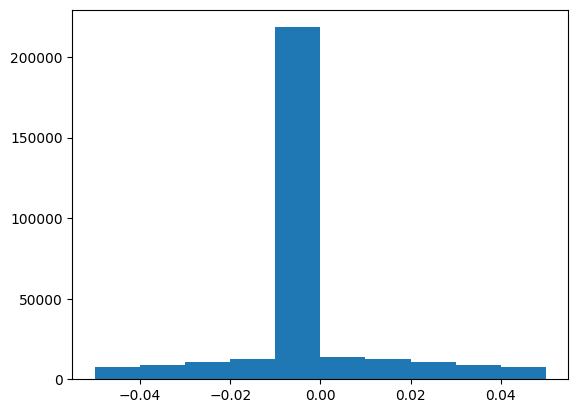

In [32]:
project_dir = os.getcwd()
compiled_data_dir = project_dir.split('code', 1)[0] + 'compiled data/'
dat_name_path = compiled_data_dir + 'metadata_goproUFP_V2_V3_15012024_predictions_added.csv'

dat = pd.read_csv(dat_name_path)

# if using V2, get rid of all the rows where spec and image labels are very different
dat['diff_col'] = dat.apply(lambda value: value.ln_ufp_num_10s_ma_image_label_raw - value.ln_ufp_num_10s_ma_spec_label_raw, axis = 1)

dat = dat.loc[(abs(dat['diff_col']) <= 0.05)]

# plot to confirm
plt.hist(dat['diff_col'])
plt.show()

In [34]:
[*dat]

['datetime',
 'image_path',
 'audio_path',
 'ln_ufp_num_10s_ma_image_label_raw',
 'ln_ufp_num_10s_ma_spec_label_raw',
 'ln_ufp_size_10s_ma_image_label_raw',
 'ln_ufp_size_10s_ma_spec_label_raw',
 'ln_noise_10s_ma_image_label_raw',
 'ln_noise_10s_ma_spec_label_raw',
 'ufp_num_10s_ma_image_label_raw',
 'ufp_num_10s_ma_spec_label_raw',
 'ufp_size_10s_ma_image_label_raw',
 'ufp_size_10s_ma_spec_label_raw',
 'noise_10s_ma_image_label_raw',
 'noise_10s_ma_spec_label_raw',
 'temp_airp',
 'wspd_airp',
 'year',
 'city',
 'pm25',
 'file_exists',
 'hardware',
 'site_id',
 'device_id',
 'file',
 'noise_10s_ma_spec_label_quartile',
 'noise_10s_ma_image_label_quartile',
 'ufp_num_10s_ma_spec_label_quartile',
 'ufp_num_10s_ma_image_label_quartile',
 'ufp_size_10s_ma_spec_label_quartile',
 'ufp_size_10s_ma_image_label_quartile',
 'set',
 'image_extension',
 'audio_extension',
 'image_name',
 'audio_name',
 'pair_pm25',
 'ln_ufp_num_ResNet50_image_raw_prediction',
 'ln_ufp_num_Xception_audio_raw_predic

In [37]:
dat = dat.loc[(dat['hardware'] == 'V2') & (dat['set'] == 'tst')]

noise_dat = dat.loc[:, ["noise_10s_ma_spec_label_raw", 
     "temp_airp",
     "wspd_airp",
    # something strange, should be image and audio for each y and arch, so twice as many
     "ln_noise_ResNet50_image_raw_prediction", 
     "ln_noise_Xception_audio_raw_prediction", 
     "ln_ufp_size_Xception_audio_raw_prediction", 
     "ln_ufp_size_ResNet50_image_raw_prediction"]]

# # create new colums, mean predictions and the log transformed outcome
# noise_dat.loc[:,['mean_noise_pred_images']] = noise_dat.apply(lambda value: value.noise_pred_images_resnet + value.noise_pred_images_xception, axis = 1)
# noise_dat.loc[:,['mean_noise_pred_spectrogram']] = noise_dat.apply(lambda value: value.noise_pred_spectrogram_resnet + value.noise_pred_spectrogram_xception, axis = 1)
# noise_dat.loc[:,['mean_ufp_size_pred_images']] = noise_dat.apply(lambda value: value.ufp_size_pred_images_resnet + value.ufp_size_pred_images_xception, axis = 1)
# noise_dat.loc[:,['mean_ufp_size_pred_spectrogram']] = noise_dat.apply(lambda value: value.ufp_size_pred_spectrogram_resnet + value.ufp_size_pred_spectrogram_xception, axis = 1)
# noise_dat.loc[:,['ln_noise_raw']] = noise_dat.apply(lambda value: np.log(value.noise_10s_ma_spec_label_raw), axis = 1)

# # a bit overdone, just leaving space in case we have a second model prediction for the means
noise_dat.loc[:,['mean_noise_pred_images']] = noise_dat.apply(lambda value: value.ln_noise_ResNet50_image_raw_prediction, axis = 1)
noise_dat.loc[:,['mean_noise_pred_spectrogram']] = noise_dat.apply(lambda value: value.ln_noise_Xception_audio_raw_prediction, axis = 1)
noise_dat.loc[:,['mean_ufp_size_pred_images']] = noise_dat.apply(lambda value: value.ln_ufp_size_ResNet50_image_raw_prediction, axis = 1)
noise_dat.loc[:,['mean_ufp_size_pred_spectrogram']] = noise_dat.apply(lambda value: value.ln_ufp_size_Xception_audio_raw_prediction, axis = 1)
noise_dat.loc[:,['ln_noise_raw']] = noise_dat.apply(lambda value: np.log(value.noise_10s_ma_spec_label_raw), axis = 1)


noise_dat

,noise_10s_ma_spec_label_raw,temp_airp,wspd_airp,ln_noise_ResNet50_image_raw_prediction,ln_noise_Xception_audio_raw_prediction,ln_ufp_size_Xception_audio_raw_prediction,ln_ufp_size_ResNet50_image_raw_prediction,mean_noise_pred_images,mean_noise_pred_spectrogram,mean_ufp_size_pred_images,mean_ufp_size_pred_spectrogram,ln_noise_raw
181182,64.67,7.9,17,4.153514,4.124436,3.074266,3.574246,4.153514,4.124436,3.574246,3.074266,4.169297
181186,68.11,7.9,17,4.200681,4.133080,3.510700,3.396478,4.200681,4.133080,3.396478,3.510700,4.221124
181210,58.38,7.9,17,4.134376,4.087533,3.510501,3.251491,4.134376,4.087533,3.251491,3.510501,4.066973
181226,72.88,7.9,17,4.164587,4.246425,3.305217,3.312613,4.164587,4.246425,3.312613,3.305217,4.288814
181231,67.06,7.9,17,4.178122,4.169342,3.097605,3.356382,4.178122,4.169342,3.356382,3.097605,4.205588
...,...,...,...,...,...,...,...,...,...,...,...,...
380893,69.84,21.5,17,4.309507,4.266845,3.634856,3.429090,4.309507,4.266845,3.429090,3.634856,4.246207
380922,71.46,21.5,17,4.236364,4.234469,3.195641,3.496870,4.236364,4.234469,3.496870,3.195641,4.269138
380970,70.89,21.0,9,4.257527,4.267630,3.570034,3.677284,4.257527,4.267630,3.677284,3.570034,4.261129
381058,72.11,20.2,10,4.238052,4.274213,3.704597,3.664834,4.238052,4.274213,3.664834,3.704597,4.278193


In [38]:
noise_dat.dtypes

noise_10s_ma_spec_label_raw                  float64
temp_airp                                    float64
wspd_airp                                      int64
ln_noise_ResNet50_image_raw_prediction       float64
ln_noise_Xception_audio_raw_prediction       float64
ln_ufp_size_Xception_audio_raw_prediction    float64
ln_ufp_size_ResNet50_image_raw_prediction    float64
mean_noise_pred_images                       float64
mean_noise_pred_spectrogram                  float64
mean_ufp_size_pred_images                    float64
mean_ufp_size_pred_spectrogram               float64
ln_noise_raw                                 float64
dtype: object

(array([  69.,  687., 1358., 1868., 2320., 2109., 1516.,  643.,  305.,
          29.]),
 array([44.38 , 48.423, 52.466, 56.509, 60.552, 64.595, 68.638, 72.681,
        76.724, 80.767, 84.81 ]),
 <BarContainer object of 10 artists>)

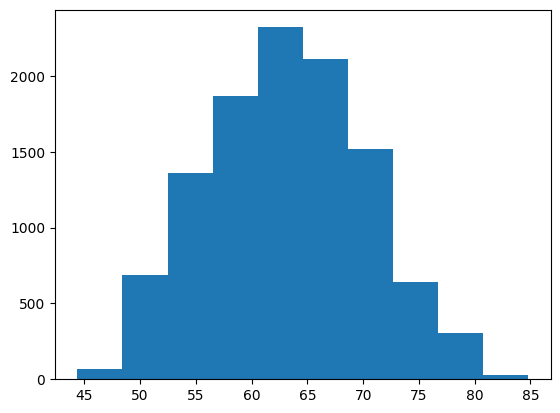

In [46]:
plt.hist(noise_dat.noise_10s_ma_spec_label_raw)
# very normal, probably don't need to transform

In [45]:
[*train_dat]

['ufp_num_10s_ma_image_label_raw',
 'temp_airp',
 'wspd_airp',
 'ln_ufp_num_ResNet50_image_raw_prediction',
 'ln_ufp_num_Xception_audio_raw_prediction',
 'ln_ufp_size_ResNet50_image_raw_prediction',
 'ln_ufp_size_Xception_audio_raw_prediction',
 'mean_ufp_num_pred_images',
 'mean_ufp_num_pred_spectrogram',
 'mean_ufp_size_pred_images',
 'mean_ufp_size_pred_spectrogram',
 'ln_ufp_num_raw']

In [48]:
# define predictors and target, windspeed included
X_predictors, y_target = noise_dat.loc[:,['mean_noise_pred_images', 'mean_noise_pred_spectrogram', 'mean_ufp_size_pred_spectrogram', 'mean_ufp_size_pred_images', 'temp_airp', 'wspd_airp']], noise_dat.loc[:,'noise_10s_ma_spec_label_raw']

# do without windspeed for now
# X_predictors, y_target = noise_dat.loc[:,['mean_noise_pred_images', 'mean_noise_pred_spectrogram', 'mean_ufp_size_pred_spectrogram', 'mean_ufp_size_pred_images', 'temp_airp']], noise_dat.loc[:,'noise_10s_ma_spec_label_raw'] # noise_10s_ma_spec_label_raw ln_noise_raw 

X_predictors_train, X_predictors_test, y_target_train, y_target_test = train_test_split(X_predictors, y_target, random_state = 1)

X_predictors.dtypes

mean_noise_pred_images            float64
mean_noise_pred_spectrogram       float64
mean_ufp_size_pred_spectrogram    float64
mean_ufp_size_pred_images         float64
temp_airp                         float64
wspd_airp                           int64
dtype: object

In [49]:
# define the ranges of the parameters we want to tune. I took these values from R code

my_params = {'learning_rate': np.linspace(0,1,11),
             'gamma': list(range(0,11,1)),
             'max_depth': list(range(1, 11, 1)),
             'min_child_weight': list(range(1,201,10)),
             'colsample_bytree': np.linspace(0.2,1,9),
             'colsample_bynode': np.linspace(0.2,1,9), 
             'colsample_bylevel': np.linspace(0.2,1,9), 
            }

In [50]:
# tune model over range of parameters
random_search_model = grid_search(x_dat = X_predictors_train, y_dat = y_target_train, 
                                  n_cv = 10, n_iterations = 5000,
                                  params = my_params, 
                                  random = True)

Best params: {'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 8, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.8}
Best score: 0.75506


In [51]:
# use tuned values to train model and evaluate in CV in training set
tuned_params = random_search_model.best_params_

my_xgb = XGBRegressor(booster='gbtree', tree_method = 'hist', objective='reg:squarederror', random_state=2,
                      min_child_weight = tuned_params['min_child_weight'], max_depth = tuned_params['max_depth'],
                      learning_rate = tuned_params['learning_rate'], gamma = tuned_params['gamma'], 
                      colsample_bytree = tuned_params['colsample_bytree'])

cross_val_score(my_xgb, X_predictors_train, y_target_train, cv=10, scoring = 'r2')

array([0.74657942, 0.72174869, 0.76481839, 0.75741368, 0.73992984,
       0.77224287, 0.75927158, 0.80076294, 0.76203812, 0.70669711])

In [52]:
# train on training data. The tuned parameters are already in my_xgb
final_model = my_xgb.fit(X_predictors_train, y_target_train)

In [53]:
# evaluate in test set

y_preds = final_model.predict(X_predictors_test)

rmse = metrics.mean_squared_error(y_target_test, y_preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

r2 = metrics.r2_score(y_target_test, y_preds)
print(f"R2 of the base model: {r2:.3f}")

RMSE of the base model: 3.454
R2 of the base model: 0.752


In [54]:
# compare to evaluation in training set (non-CV)

y_preds = final_model.predict(X_predictors_train)

rmse = metrics.mean_squared_error(y_target_train, y_preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

r2 = metrics.r2_score(y_target_train, y_preds)
print(f"R2 of the base model: {r2:.3f}")

RMSE of the base model: 3.138
R2 of the base model: 0.803


In [55]:
# save model https://subscription.packtpub.com/book/data/9781838552862/5/ch05lvl1sec39/saving-and-loading-a-model

final_model.save_model('/home/scott/Dropbox/IMAGINE Project/MSSI_Project/Current IMAGINE Models/xgboost_models/noise_xgboost.model')

/home/scott/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:33:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [56]:
loaded_model = xgb.Booster({'nthread': 2})

loaded_model.load_model('/home/scott/Dropbox/IMAGINE Project/MSSI_Project/Current IMAGINE Models/xgboost_models/noise_xgboost.model')

In [57]:
# compare to evaluation in training set (non-CV)

train_reg = xgb.DMatrix(X_predictors_train) # even though I didn't pre-process the trainning this way, this is what it expects, I'm guessing this happened behind the scenes somewhere. no biggie

y_preds = loaded_model.predict(train_reg)

rmse = metrics.mean_squared_error(y_target_train, y_preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

r2 = metrics.r2_score(y_target_train, y_preds)
print(f"R2 of the base model: {r2:.3f}")

RMSE of the base model: 3.138
R2 of the base model: 0.803


(array([  36.,  141.,  619., 1046., 1547., 2106., 1471.,  703.,  292.,
         217.]),
 array([44.02808762, 47.64314651, 51.25820541, 54.87326431, 58.48832321,
        62.1033783 , 65.71843719, 69.33349609, 72.94855499, 76.56361389,
        80.17867279]),
 <BarContainer object of 10 artists>)

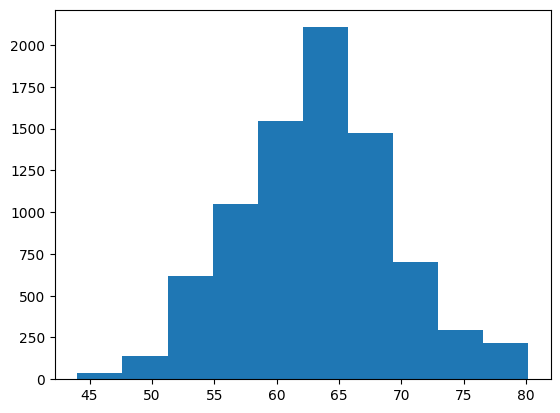

In [60]:
y_preds

In [63]:
[*X_predictors_train]

['mean_noise_pred_images',
 'mean_noise_pred_spectrogram',
 'mean_ufp_size_pred_spectrogram',
 'mean_ufp_size_pred_images',
 'temp_airp',
 'wspd_airp']

(array([  14.,   30.,   79.,  629., 1161., 2021., 2487., 1202.,  452.,
         103.]),
 array([3.7035956 , 3.77628484, 3.84897408, 3.92166332, 3.99435256,
        4.0670418 , 4.13973104, 4.21242028, 4.28510952, 4.35779876,
        4.430488  ]),
 <BarContainer object of 10 artists>)

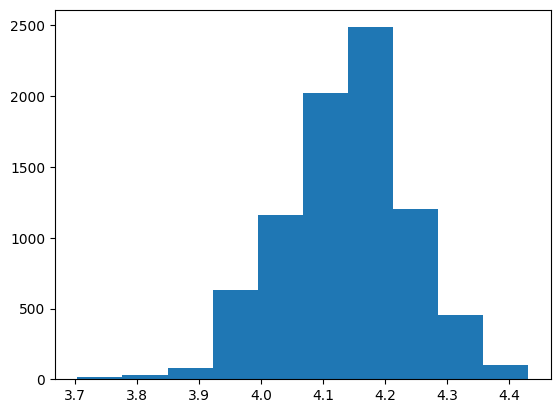

In [68]:
plt.hist(X_predictors_train.mean_noise_pred_images)

In [ ]:
# scrap below

In [ ]:
X_predictors.dtypes

In [ ]:
dtrain_reg = xgb.DMatrix(X_predictors_train, y_target_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_predictors_test, y_target_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"} 

In [ ]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 1000

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval = 100,
   early_stopping_rounds = 500
   )

In [ ]:
preds = model.predict(dtest_reg)

In [ ]:
import sklearn.metrics as metrics

rmse = metrics.mean_squared_error(y_target_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

r2 = metrics.r2_score(y_target_test, preds)
print(f"R2 of the base model: {r2:.3f}")

note that .train vs .fit is basically the same, just using different APIs https://stackoverflow.com/questions/73178041/xgboost-fit-vs-xgboost-train

.train needs the Dmatrix, it's from the Learning API
.fit can take a pd df or np array


regression can use gbtree or gblinear, probably doesn't make a huge difference https://stats.stackexchange.com/questions/201619/xgboost-what-is-the-difference-between-the-tree-booster-and-the-linear-booster

other parameters: https://xgboost.readthedocs.io/en/stable/parameter.html



In [ ]:
my_xgb = XGBRegressor(booster = 'gbtree', 
                      objective = 'reg:squarederror', 
                      max_depth=5, # 1 - 10
                      gamma = 5, # 0 = 10
                      min_child_weight = 100, # 1-200
                      colsample_bytree = 0.6, # 0.2-1
                      learning_rate=0.1, # eta, 0 - 1
                      n_estimators=100, # R didn't have
                      random_state=2, # R didn't have
                      n_jobs=-1) # R didn't have

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
# scores = cross_val_score(my_xgb, X_predictors, y_target, cv=kfold)

scores = cross_val_score(my_xgb, X_predictors_train, y_target_train, cv=5)
print('Squared Error:', np.round(scores, 2))
print('Mean Squared Error: %0.2f' % (scores.mean()))

In [ ]:
my_xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', random_state=2)
prams = params = {'n_estimators': [100,200,300]}
my_grid = GridSearchCV(xgb, params, cv=5, n_jobs=-1)


In [59]:
my_grid.fit(X_predictors_train, y_target_train)

NameError: name 'my_grid' is not defined